# Model Report

In [1]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import sampling_pymc3_models_cli as sampling
from src.data_processing import common as dphelp
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_pipeline_test_model import SpecletTestModel
from src.plot.color_pal import SeabornColor

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

Parameters for papermill:

- `MODEL`: which model was tested
- `MODEL_NAME`: name of the model
- `DEBUG`: if in debug mode or not
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"

## Setup

### Papermill parameters

In [2]:
MODEL = ""
MODEL_NAME = ""
DEBUG = True
FIT_METHOD = ""

In [3]:
# Parameters
MODEL = "speclet-three"
MODEL_NAME = "SpecletThree-debug"
DEBUG = True
FIT_METHOD = "MCMC"

In [4]:
assert FIT_METHOD in ["ADVI", "MCMC"]

In [5]:
speclet_model = sampling.sample_speclet_model(
    MODEL,
    name=MODEL_NAME,
    fit_method=FIT_METHOD,
    debug=DEBUG,
    random_seed=RANDOM_SEED,
    touch=False,
)

[05/26/21 17:52:23] INFO     Cache directory: /n/data1/hms/db ]8;id=1622065943.5612376-617654;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:87
                             mi/park/Cook/speclet/models

                    INFO     Sampling in debug mode.          ]8;id=1622065943.5675716-871392;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:92

                    INFO     Sampling 'speclet-three' with    ]8;id=1622065943.5710244-875219;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:94
                             custom name 'SpecletThree-debug'

                    INFO     Running model build method.     ]8;id=1622065943.5858395-330717;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:102

                    INFO     Calling `model_specification()` method.     ]8;id=1622065943.5897272-83062;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:166

                    INFO     Beginning PyMC3 model specification.        ]8;id=1622065943.5931268-306773;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:261

                    WARNING  Dropping data points of sgRNA that    ]8;id=1622065943.8488016-24302;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:125
                             map to multiple genes.

                    WARNING  Dropping data points with missing     ]8;id=1622065943.8701103-89544;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:131
                             copy number.

                    INFO     Getting Theano shared variables.            ]8;id=1622065943.9198337-596893;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:268

                    INFO     Creating PyMC3 model (non-centered          ]8;id=1622065943.9340699-576231;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:277
                             parameterization).

[05/26/21 17:52:40] INFO     Running MCMC fitting method.    ]8;id=1622065960.5458157-276046;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:114

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1622065960.5519252-533385;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     Returning results from cache.               ]8;id=1622065960.556521-186920;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:263

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1622065960.5599961-46665;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

[05/26/21 17:52:41] INFO     finished; execution time: 0.29  ]8;id=1622065961.0086212-322037;file:///n/data1/hms/dbmi/park/Cook/speclet/src/command_line_interfaces/sampling_pymc3_models_cli.py\sampling_pymc3_models_cli.py]8;;\:134
                             minutes

In [6]:
if FIT_METHOD == "ADVI":
    model_az, advi_approx = speclet_model.advi_results
else:
    model_az = speclet_model.mcmc_results

### Data

In [7]:
data = speclet_model.data_manager.get_data()
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.584371,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.584371,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0


### Cached model fit

In [8]:
print(speclet_model.model)

      μ_h ~ Normal
σ_h_log__ ~ TransformedDistribution
      μ_g ~ Normal
σ_g_log__ ~ TransformedDistribution
      μ_b ~ Normal
σ_b_log__ ~ TransformedDistribution
σ_σ_log__ ~ TransformedDistribution
  σ_log__ ~ TransformedDistribution
 h_offset ~ Normal
 g_offset ~ Normal
 b_offset ~ Normal
      σ_h ~ HalfNormal
      σ_g ~ HalfNormal
      σ_b ~ HalfNormal
      σ_σ ~ HalfNormal
        σ ~ HalfNormal
        h ~ Deterministic
        g ~ Deterministic
        b ~ Deterministic
        μ ~ Deterministic
      lfc ~ Normal


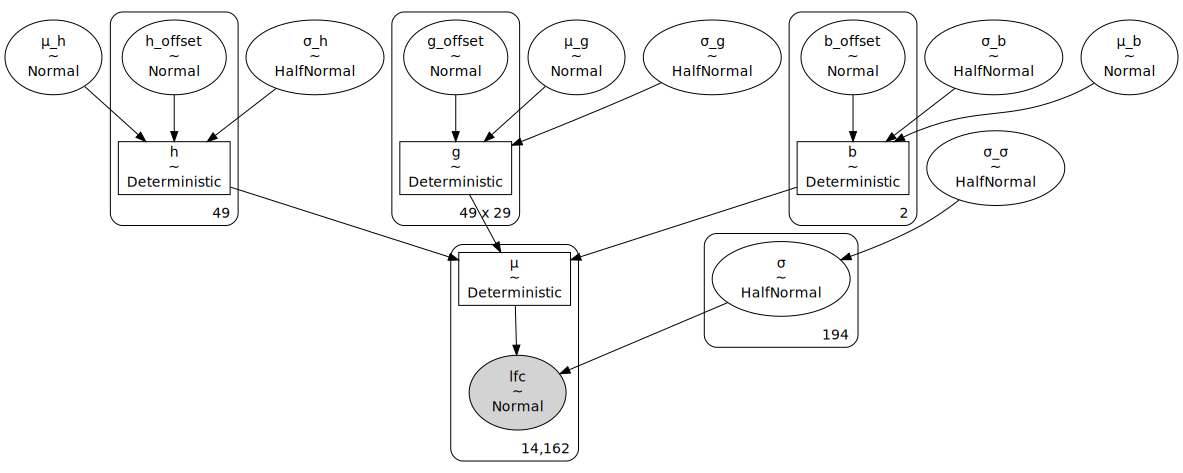

In [9]:
pm.model_to_graphviz(speclet_model.model)

## Fit diagnostics

In [10]:
if FIT_METHOD == "ADVI":
    pmanal.plot_vi_hist(advi_approx).draw()
    plt.show()
else:
    print("R-HAT")
    print(az.rhat(model_az))
    print("=" * 60)
    print("BFMI")
    print(az.bfmi(model_az))

R-HAT
<xarray.Dataset>
Dimensions:         (b_dim_0: 2, b_offset_dim_0: 2, g_dim_0: 49, g_dim_1: 29, g_offset_dim_0: 49, g_offset_dim_1: 29, h_dim_0: 49, h_offset_dim_0: 49, μ_dim_0: 14162, σ_dim_0: 194)
Coordinates:
  * h_offset_dim_0  (h_offset_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48
  * g_offset_dim_0  (g_offset_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48
  * g_offset_dim_1  (g_offset_dim_1) int64 0 1 2 3 4 5 6 ... 23 24 25 26 27 28
  * b_offset_dim_0  (b_offset_dim_0) int64 0 1
  * σ_dim_0         (σ_dim_0) int64 0 1 2 3 4 5 6 ... 188 189 190 191 192 193
  * h_dim_0         (h_dim_0) int64 0 1 2 3 4 5 6 7 ... 41 42 43 44 45 46 47 48
  * g_dim_0         (g_dim_0) int64 0 1 2 3 4 5 6 7 ... 41 42 43 44 45 46 47 48
  * g_dim_1         (g_dim_1) int64 0 1 2 3 4 5 6 7 ... 21 22 23 24 25 26 27 28
  * b_dim_0         (b_dim_0) int64 0 1
  * μ_dim_0         (μ_dim_0) int64 0 1 2 3 4 ... 14157 14158 14159 14160 14161
Data variables: (12/15)
    μ_h             float64 1.001
   

## Model parameters

In [11]:
def check_shape(trace: np.ndarray) -> np.ndarray:
    if len(trace.shape) == 1:
        return trace[:, None]
    return trace


def add_hdi(p: gg.ggplot, values: np.ndarray, color: str) -> gg.ggplot:
    m = np.mean(values)
    hdi = az.hdi(values, hdi_prob=0.89).flatten()
    p = (
        p
        + gg.geom_vline(xintercept=m, color=color)
        + gg.geom_vline(xintercept=hdi, color=color, linetype="--")
    )
    return p


def variable_distribution_plot(var, trace: np.ndarray, max_plot=20000) -> gg.ggplot:
    trace = check_shape(trace)

    # Sample 25% of the trace.
    d = pd.DataFrame(trace).melt().assign(variable=lambda d: d.variable.astype("str"))
    d_summaries = d.groupby(["variable"])["value"].mean().reset_index(drop=False)

    if d.shape[0] > max_plot:
        d = d.sample(n=max_plot)
    else:
        d = d.sample(frac=0.2)

    p = (
        gg.ggplot(d, gg.aes(x="value"))
        + gg.geom_density(alpha=0.1)
        + gg.geom_vline(xintercept=0, color="black", size=0.7, alpha=0.7, linetype="--")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(legend_position="none", figure_size=(6.5, 3))
        + gg.labs(x="posterior", y="density", title=f"Posterior distirbution of {var}")
    )

    c = SeabornColor.blue

    if len(d_summaries) > 1:
        p = p + gg.geom_rug(
            data=d_summaries, sides="b", alpha=0.5, color=c, length=0.08
        )
    else:
        p = add_hdi(p, trace.flatten(), color=c)

    return p

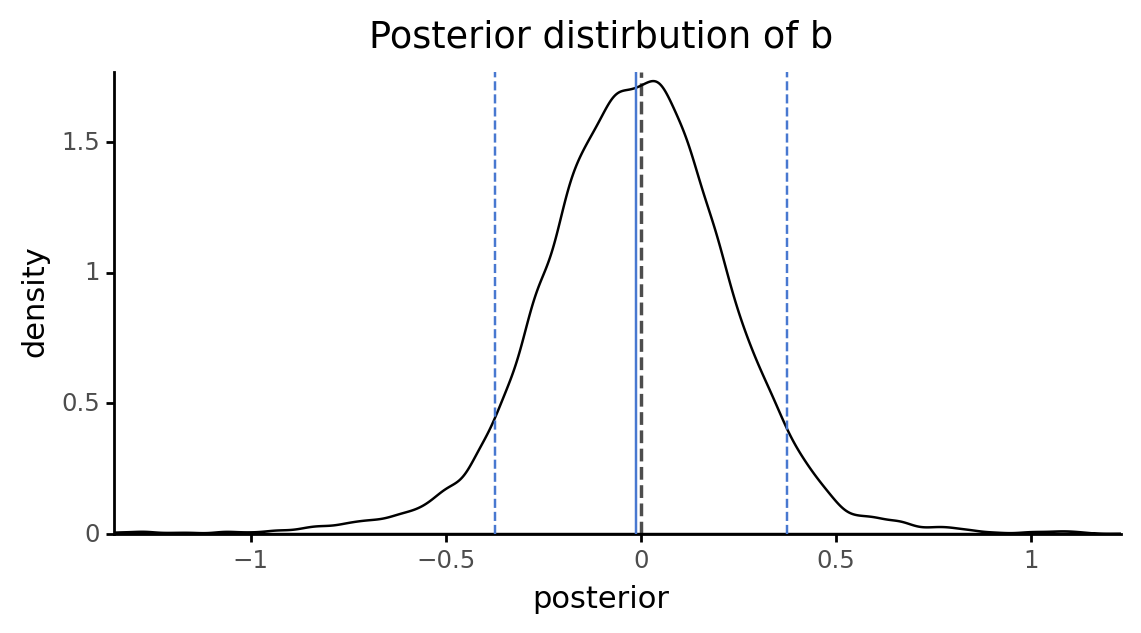

<ggplot: (2955195510324)>


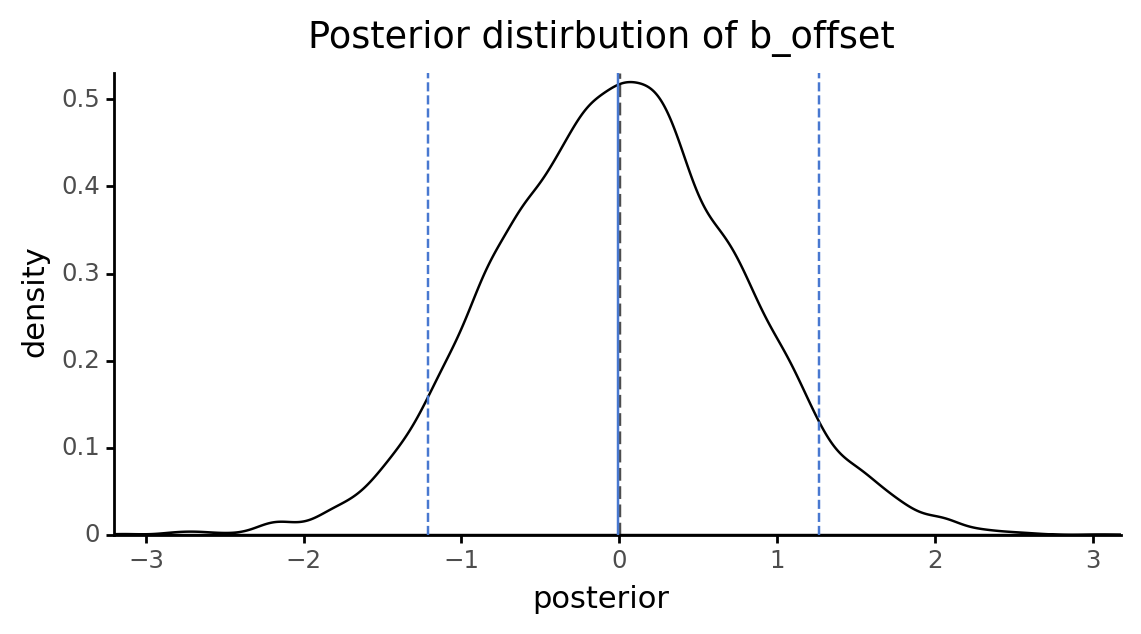

<ggplot: (2955195593295)>


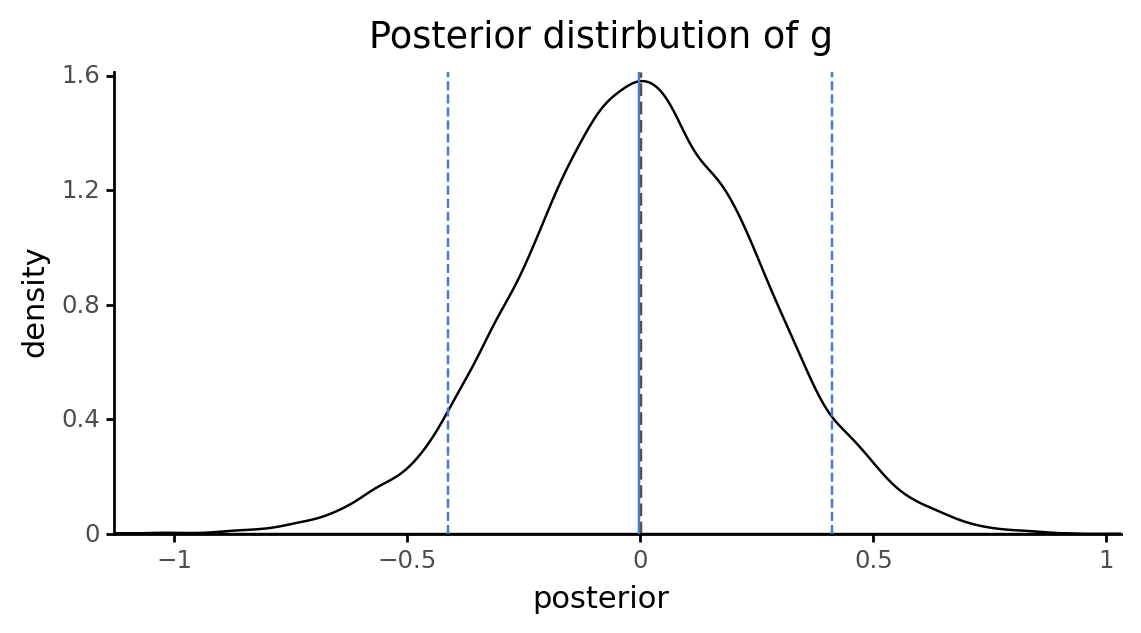

<ggplot: (2955195613678)>


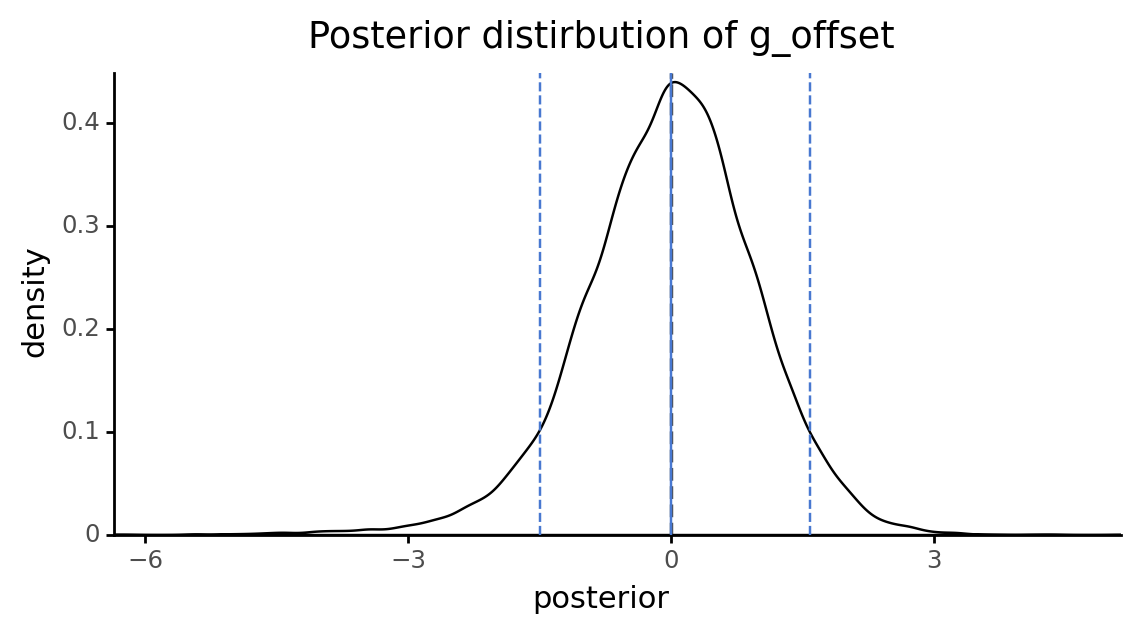

<ggplot: (2955195511101)>


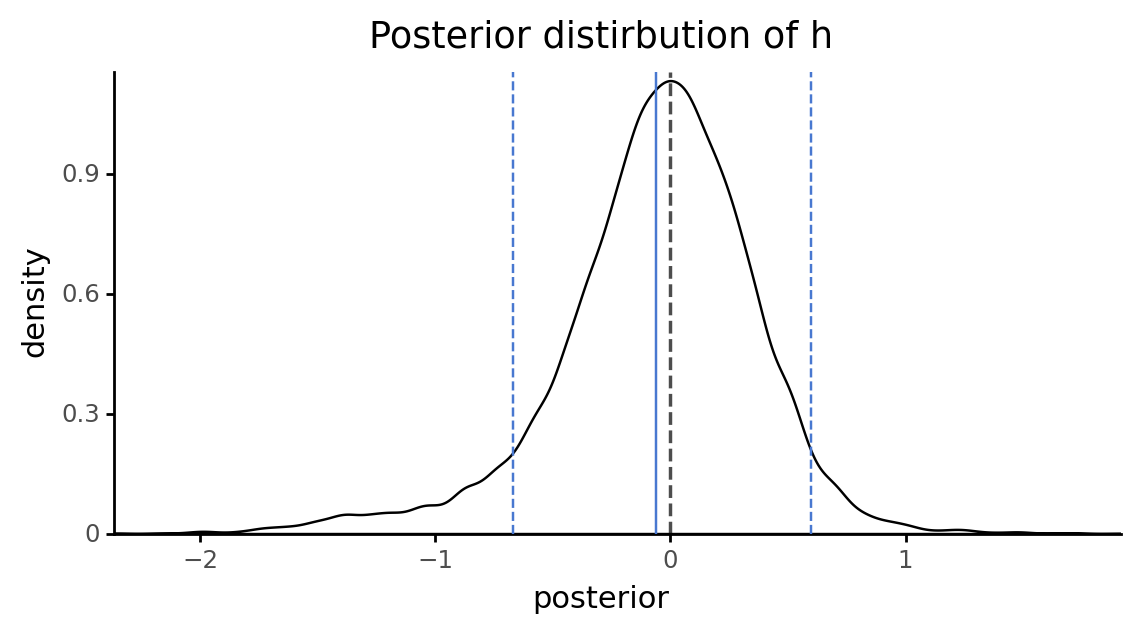

<ggplot: (2955195402632)>


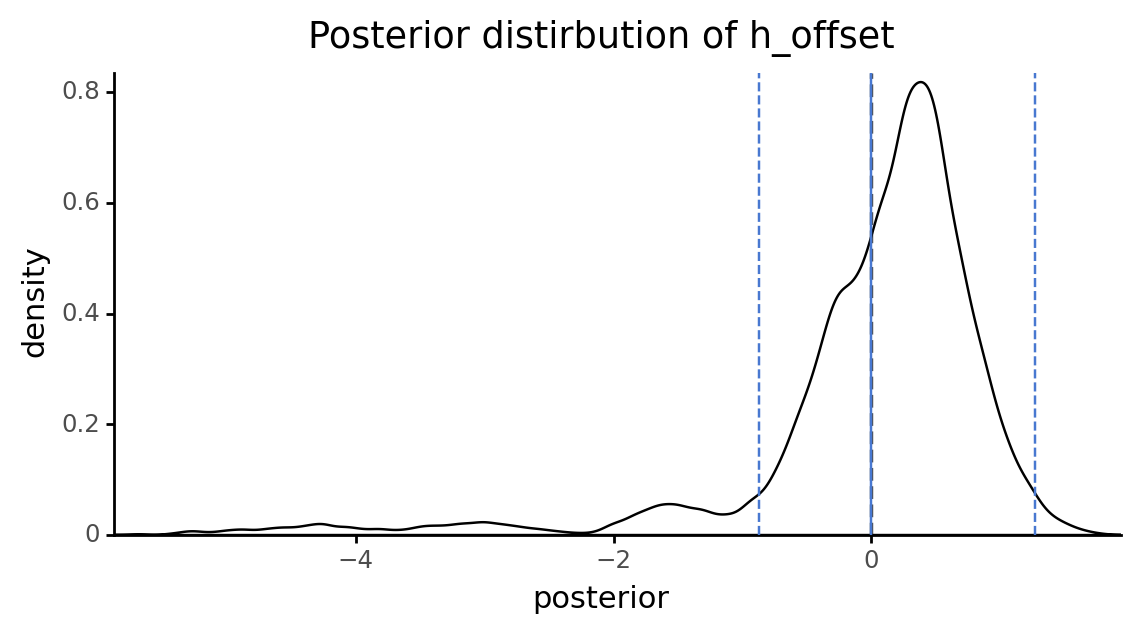

<ggplot: (2955197789992)>


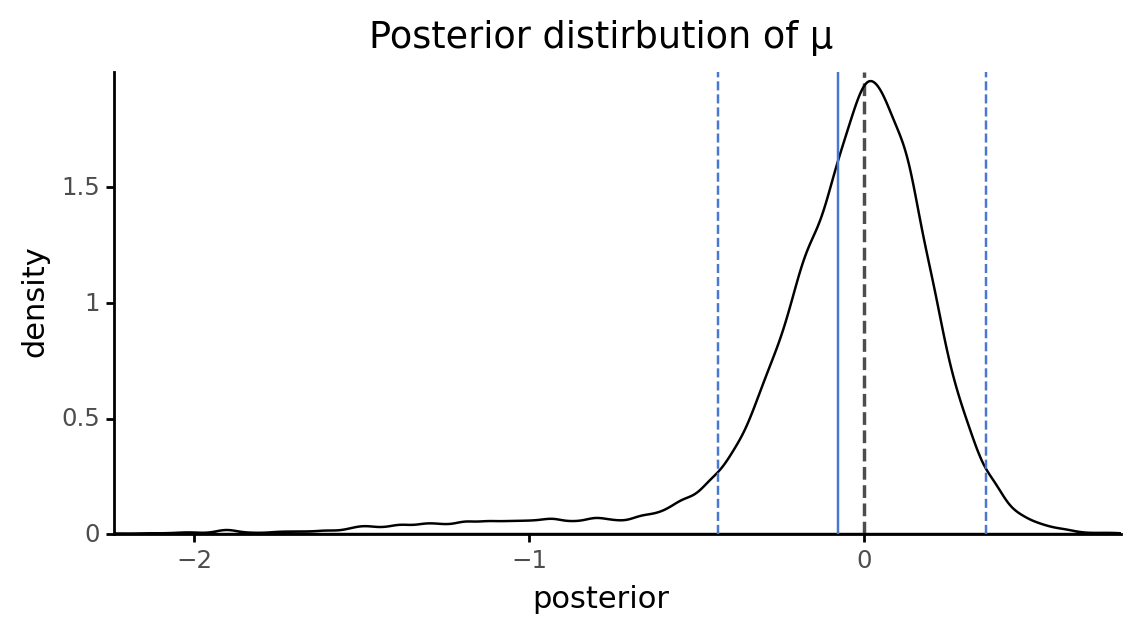

<ggplot: (2955195460705)>


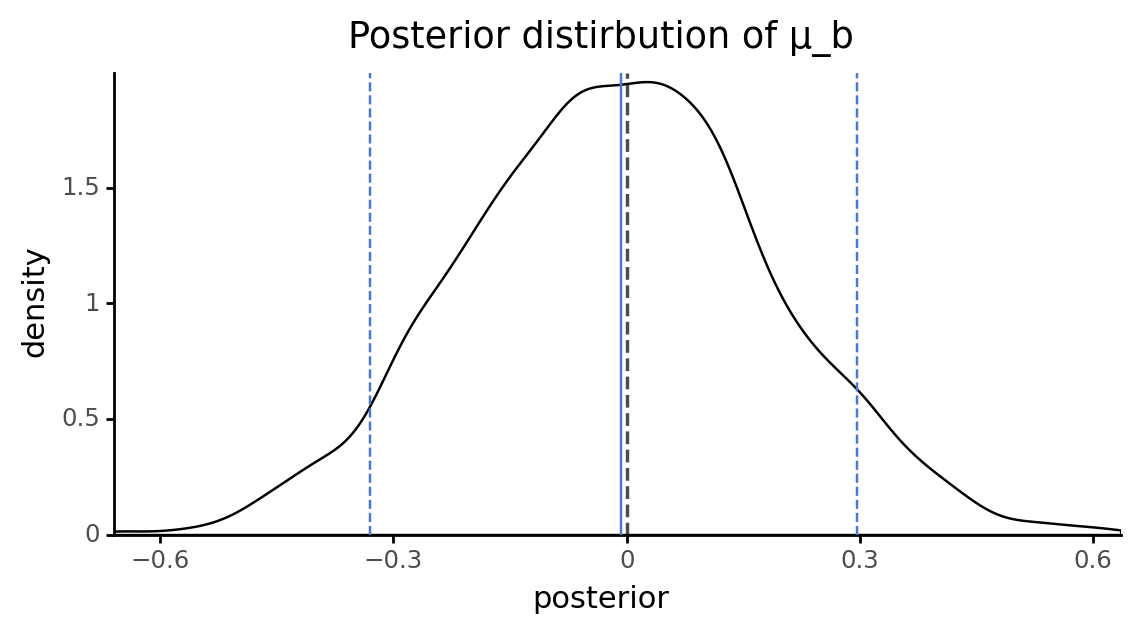

<ggplot: (2955195589768)>


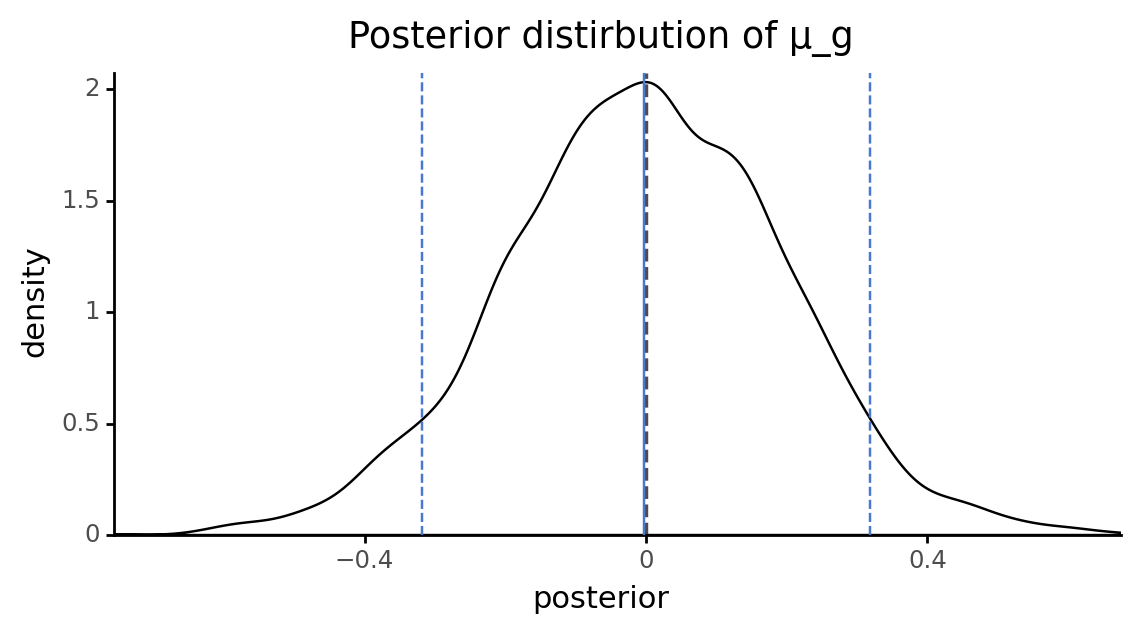

<ggplot: (2955195402710)>


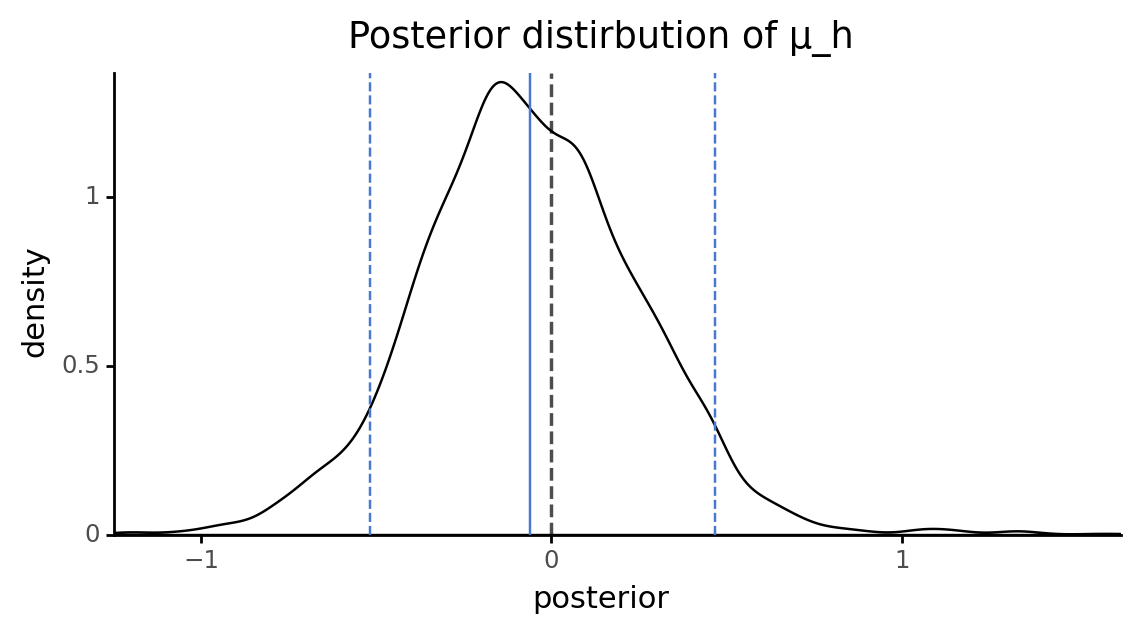

<ggplot: (2955184684963)>


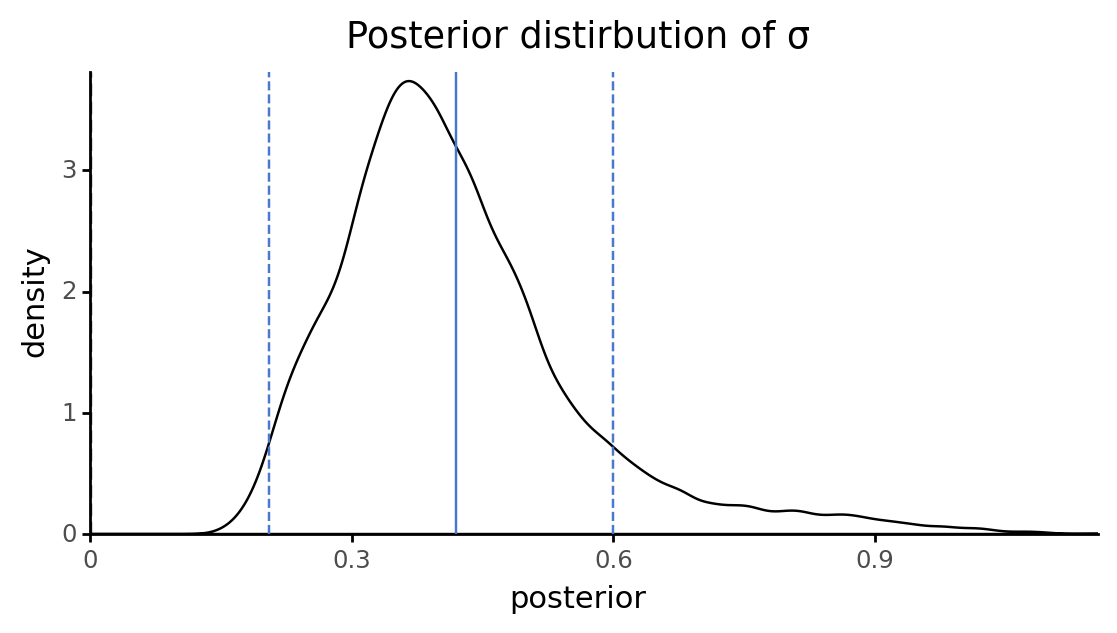

<ggplot: (2955196425533)>


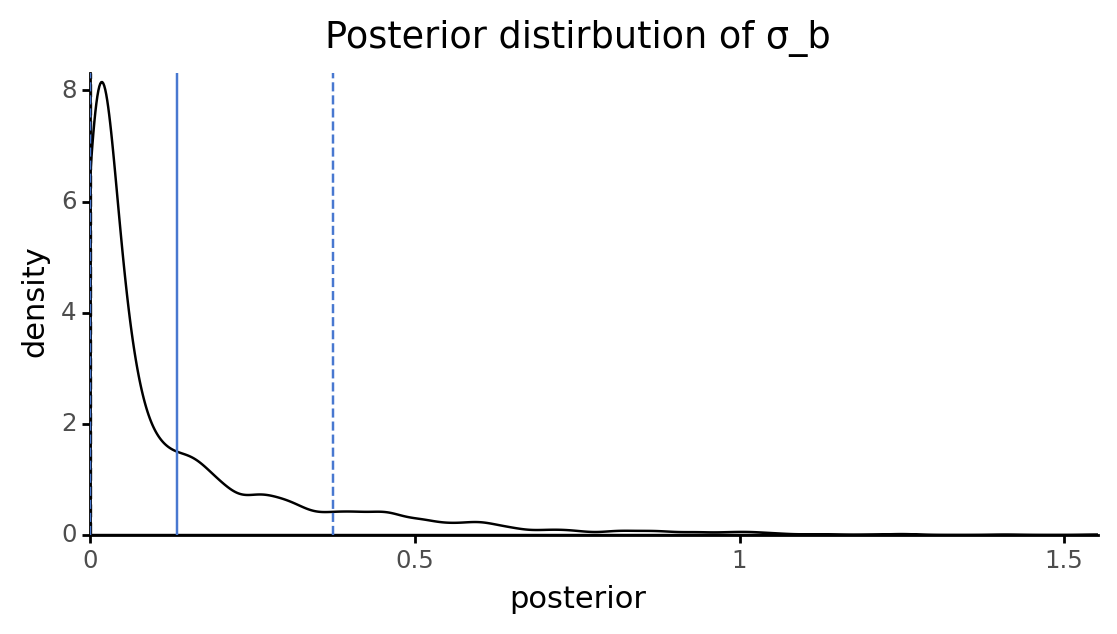

<ggplot: (2955195613465)>


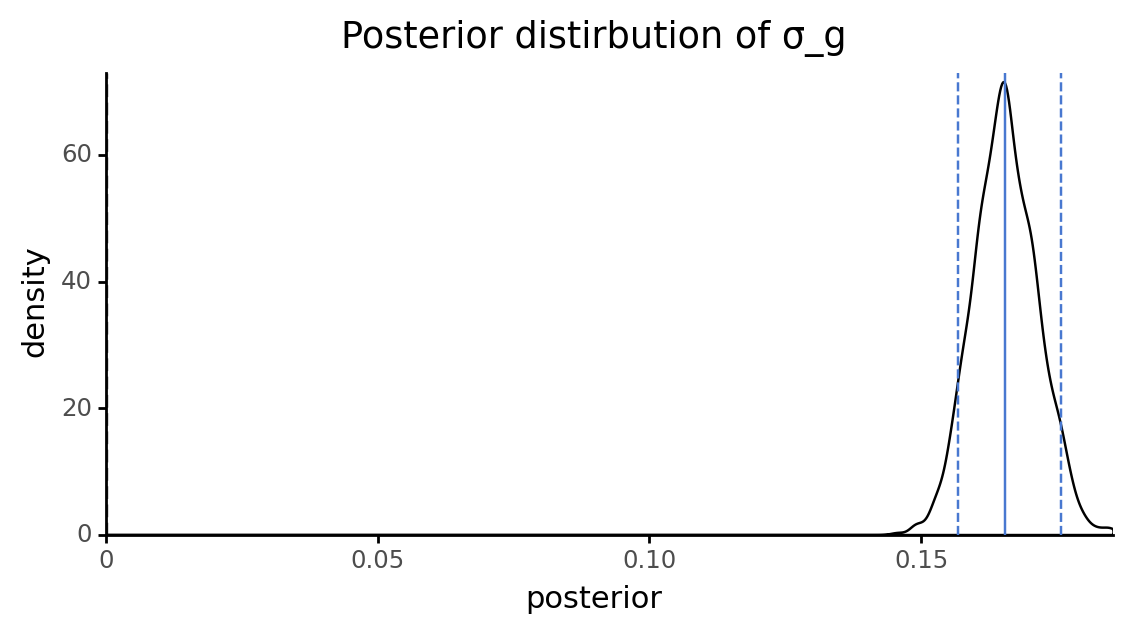

<ggplot: (2955181865180)>


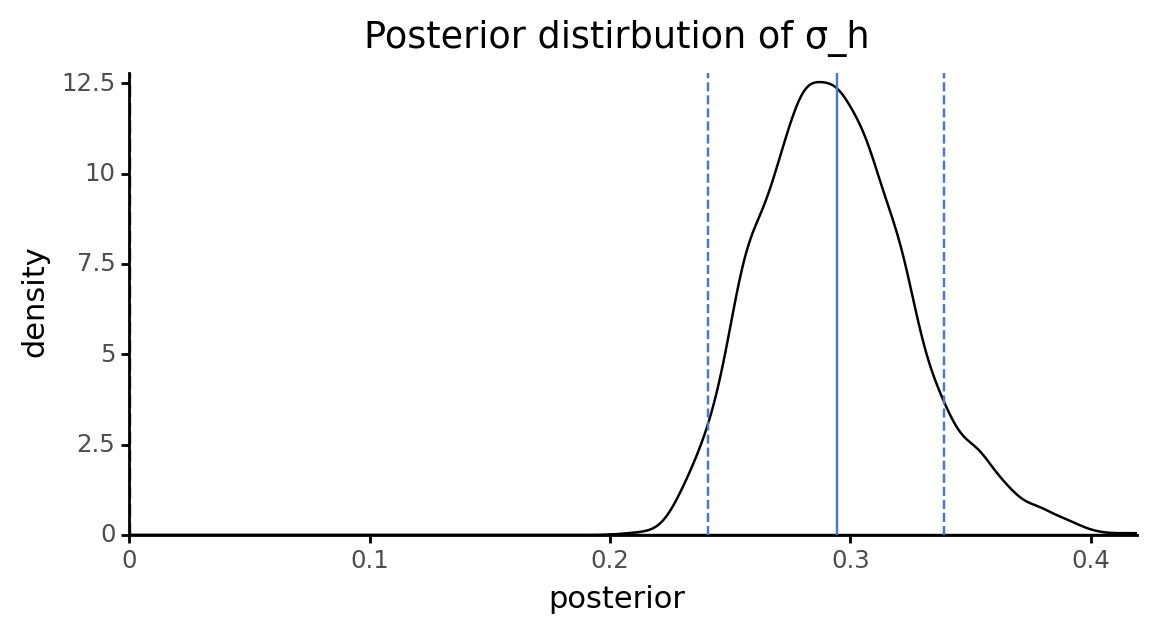

<ggplot: (2955196425533)>


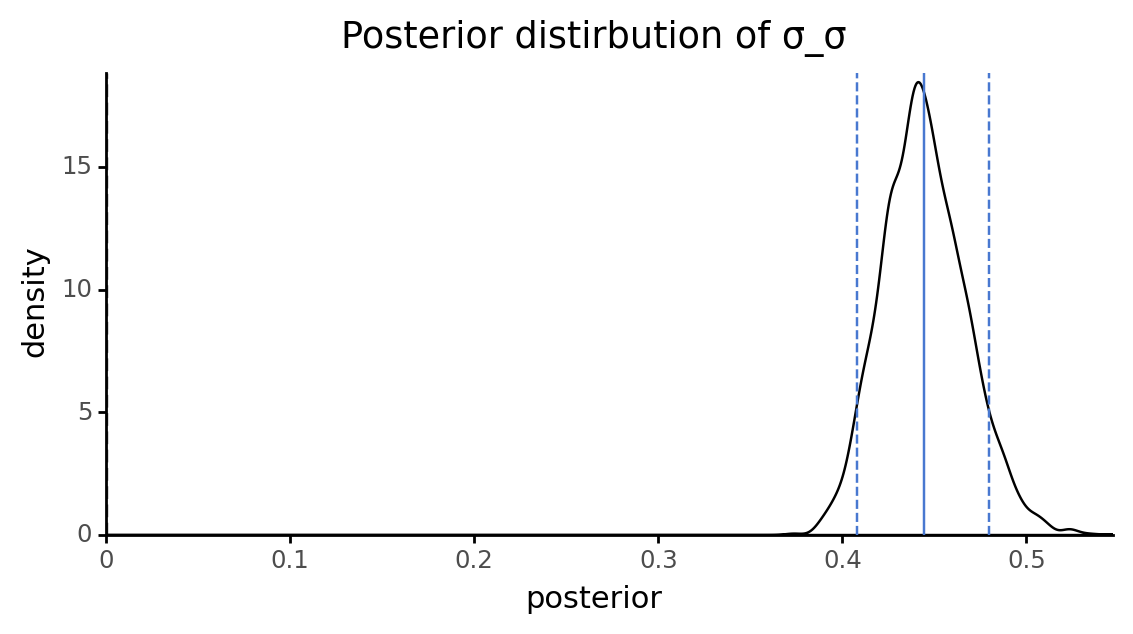

<ggplot: (2955195511068)>


In [12]:
ignore_vars = "μ"
vars_to_inspect = model_az.posterior.keys()
vars_to_inspect = [v for v in vars_to_inspect if not "log" in v]
vars_to_inspect.sort()

for var in vars_to_inspect:
    trace = model_az.posterior[var]
    if trace.shape[1] == data.shape[0]:
        # Do not plot the final deterministic mean (usually "μ").
        continue
    try:
        print(variable_distribution_plot(var, model_az.posterior[var].values.flatten()))
    except Exception as err:
        print(f"Skipping variable '{var}'.")
        print(err)

In [13]:
if isinstance(speclet_model, SpecletTestModel):
    raise KeyboardInterrupt()

## Model predictions

In [14]:
predictions = model_az.posterior_predictive
pred_summary = pmanal.summarize_posterior_predictions(
    predictions["lfc"].values,
    merge_with=data,
    calc_error=True,
    observed_y="lfc",
)
pred_summary.head()

/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/7988df32/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,...,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated,error
0,0.142528,-0.585385,0.849915,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,...,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.584371,0,-0.113036
1,0.140227,-0.609182,0.823160,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,...,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.584371,0,0.285790
2,-0.056855,-0.745563,0.680929,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0,0.065481
3,-0.061012,-0.788797,0.683046,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0,0.341834
4,-0.074350,-0.737300,0.669279,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.053926,0,0.314165


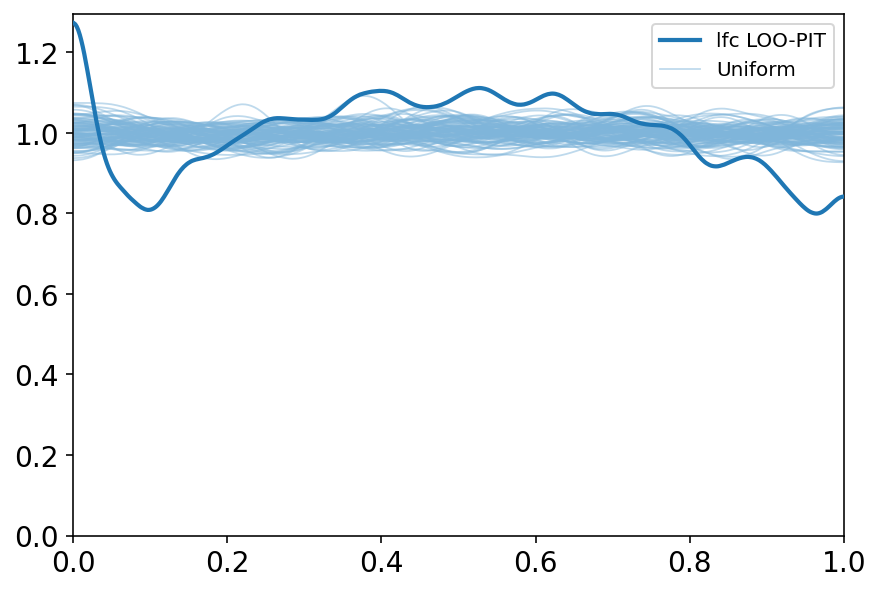

In [15]:
try:
    az.plot_loo_pit(model_az, y="lfc")
except Exception as e:
    print(e)

In [16]:
model_loo = az.loo(model_az, pointwise=True)
print(model_loo)

Computed from 16000 by 14162 log-likelihood matrix

         Estimate       SE
elpd_loo -7748.66   111.72
p_loo     1203.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     14012   98.9%
 (0.5, 0.7]   (ok)         124    0.9%
   (0.7, 1]   (bad)         25    0.2%
   (1, Inf)   (very bad)     1    0.0%



/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/7988df32/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

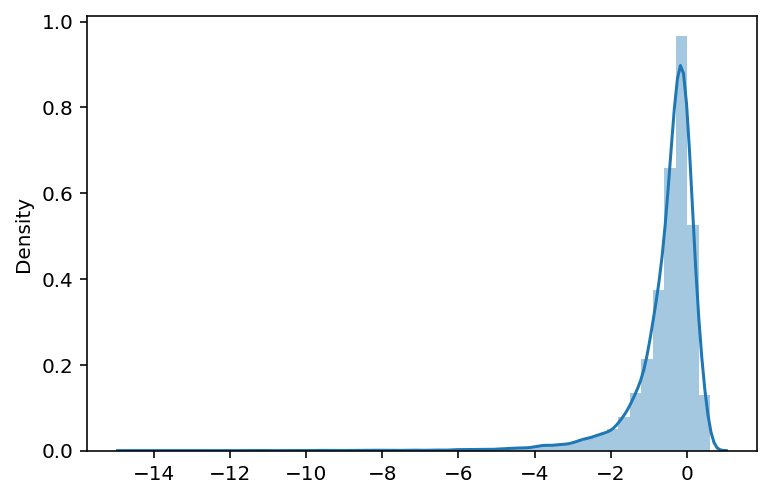

In [17]:
sns.distplot(model_loo.loo_i.values);

In [18]:
pred_summary["loo"] = model_loo.loo_i.values

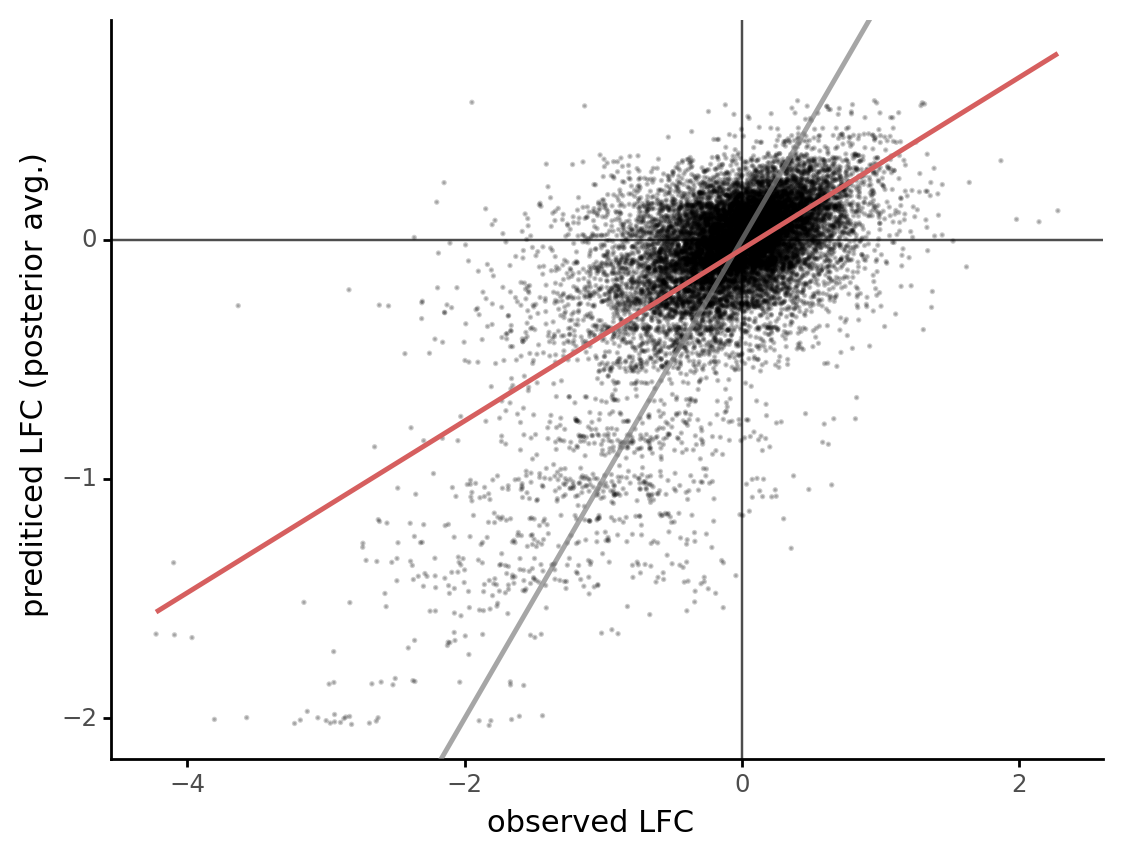

<ggplot: (2955188820794)>

In [19]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.geom_abline(slope=1, intercept=0, size=1, alpha=0.7, color="grey")
    + gg.geom_smooth(method="glm", color=SeabornColor.red, size=1, alpha=0.7, se=False)
    + gg.labs(x="observed LFC", y="prediticed LFC (posterior avg.)")
)

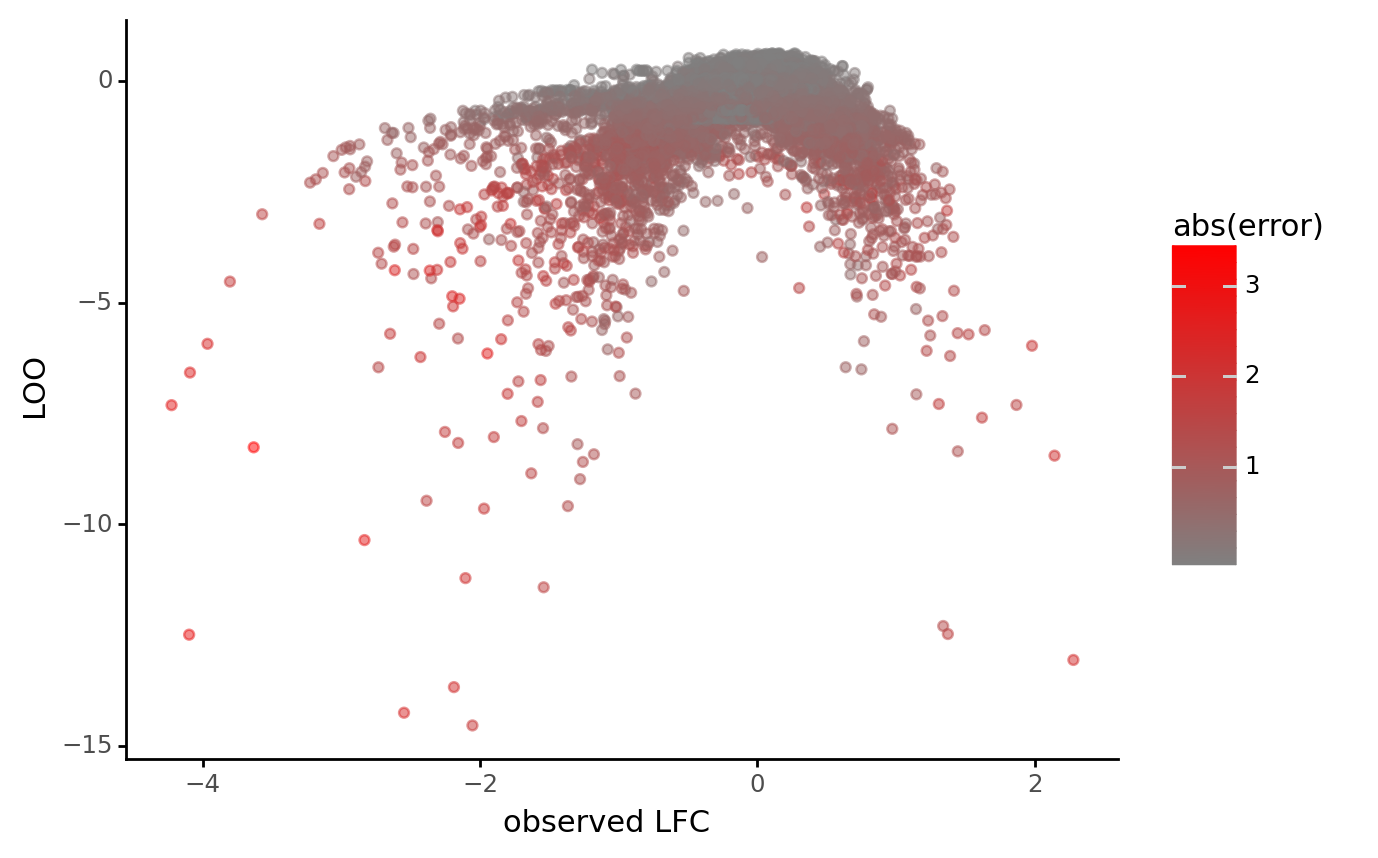

<ggplot: (2955195593253)>

In [20]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="loo"))
    + gg.geom_point(gg.aes(color="np.abs(error)"), alpha=0.5)
    + gg.scale_color_gradient(low="grey", high="red")
    + gg.theme()
    + gg.labs(x="observed LFC", y="LOO", color="abs(error)")
)

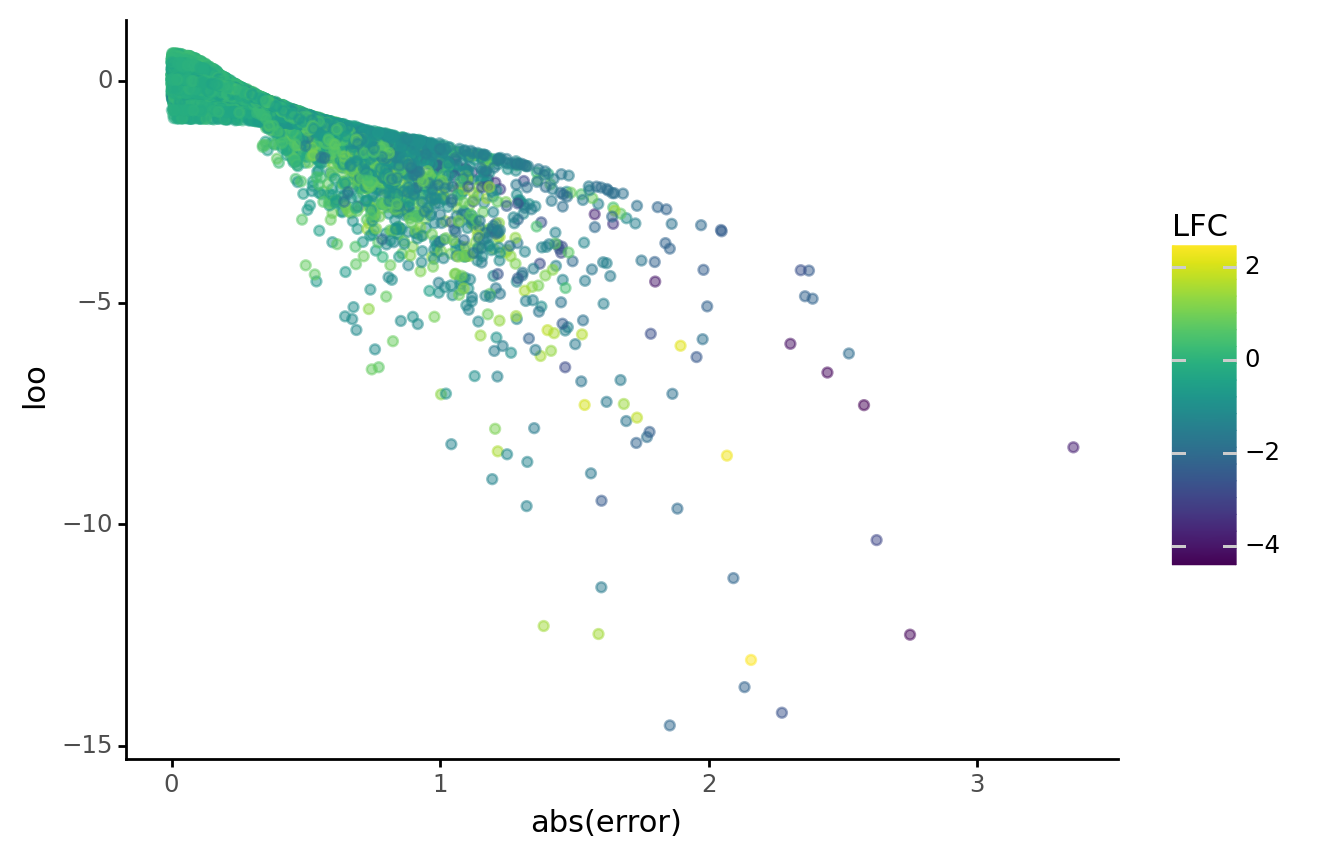

<ggplot: (2955198282204)>

In [21]:
(
    gg.ggplot(pred_summary, gg.aes(x="np.abs(error)", y="loo"))
    + gg.geom_point(gg.aes(color="lfc"), alpha=0.5)
    + gg.labs(x="abs(error)", y="loo", color="LFC")
)

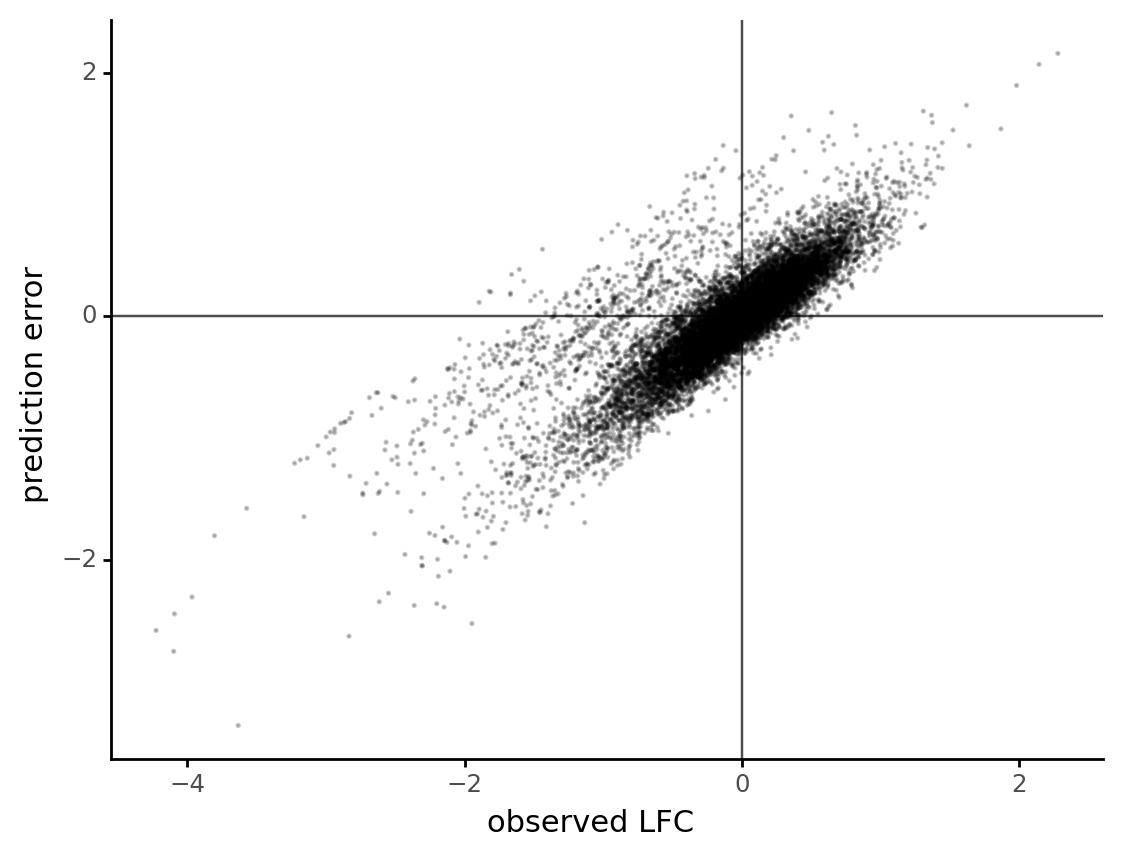

<ggplot: (2955129750809)>

In [22]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="observed LFC", y="prediction error")
)

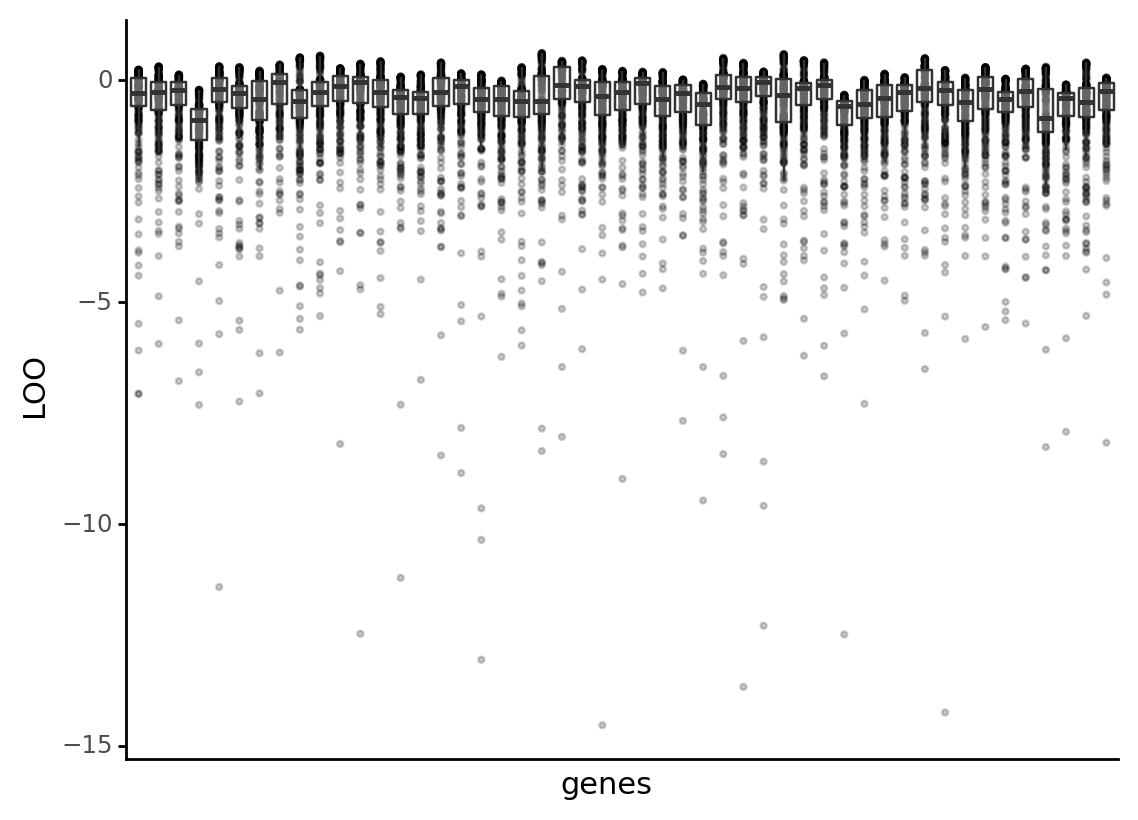

<ggplot: (2955507205455)>

In [23]:
(
    gg.ggplot(pred_summary, gg.aes(x="hugo_symbol", y="loo"))
    + gg.geom_point(alpha=0.2, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(axis_text_x=gg.element_blank(), axis_ticks_major_x=gg.element_blank())
    + gg.labs(x="genes", y="LOO")
)

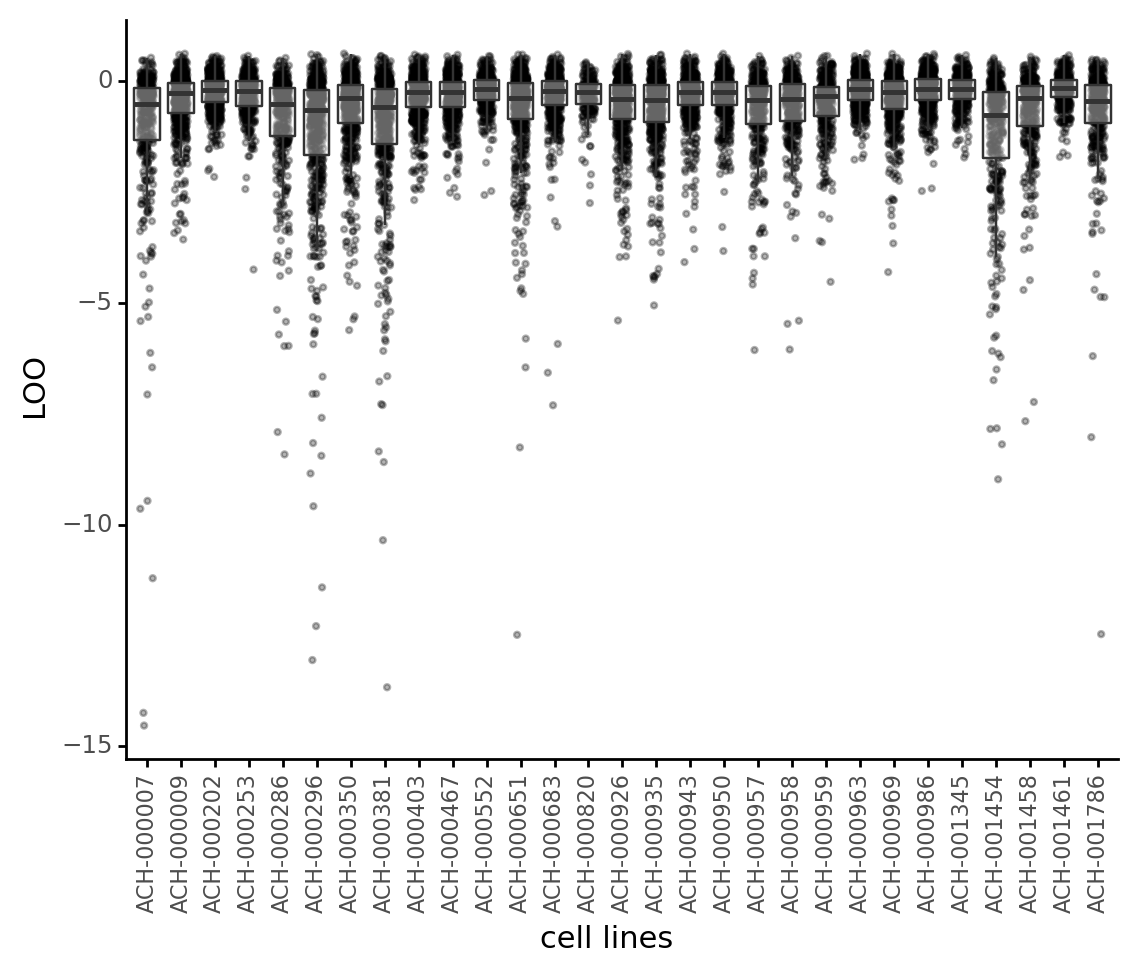

<ggplot: (2955198893126)>

In [24]:
(
    gg.ggplot(pred_summary, gg.aes(x="depmap_id", y="loo"))
    + gg.geom_jitter(width=0.2, alpha=0.3, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=8),
    )
    + gg.labs(x="cell lines", y="LOO")
)

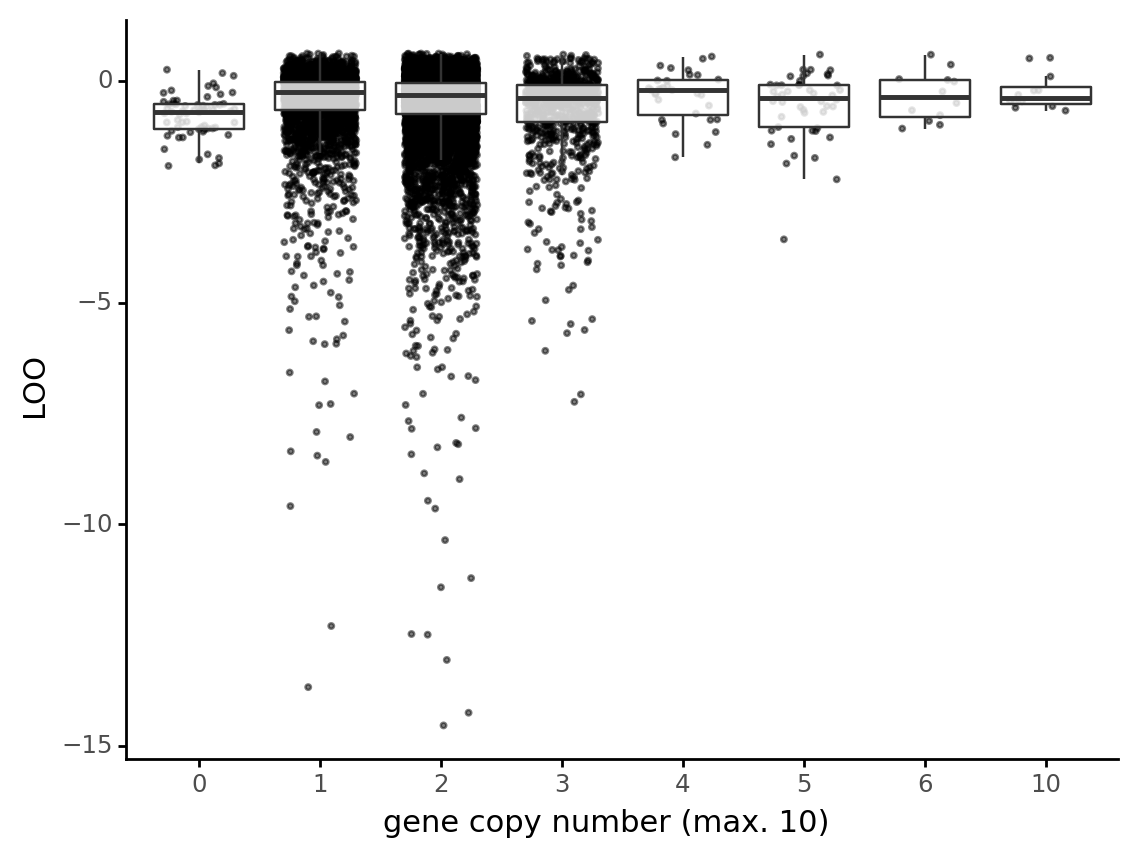

<ggplot: (2955198889997)>

In [25]:
# Remove samples without gene CN data.
ppc_df_no_missing = pred_summary.copy()[~pred_summary.gene_cn.isna()]
ppc_df_no_missing["binned_gene_cn"] = [
    np.min([round(x), 10]) for x in ppc_df_no_missing.gene_cn
]

(
    gg.ggplot(ppc_df_no_missing, gg.aes(x="factor(binned_gene_cn)", y="loo"))
    + gg.geom_jitter(size=0.6, alpha=0.5, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.8)
    + gg.labs(x="gene copy number (max. 10)", y="LOO")
)

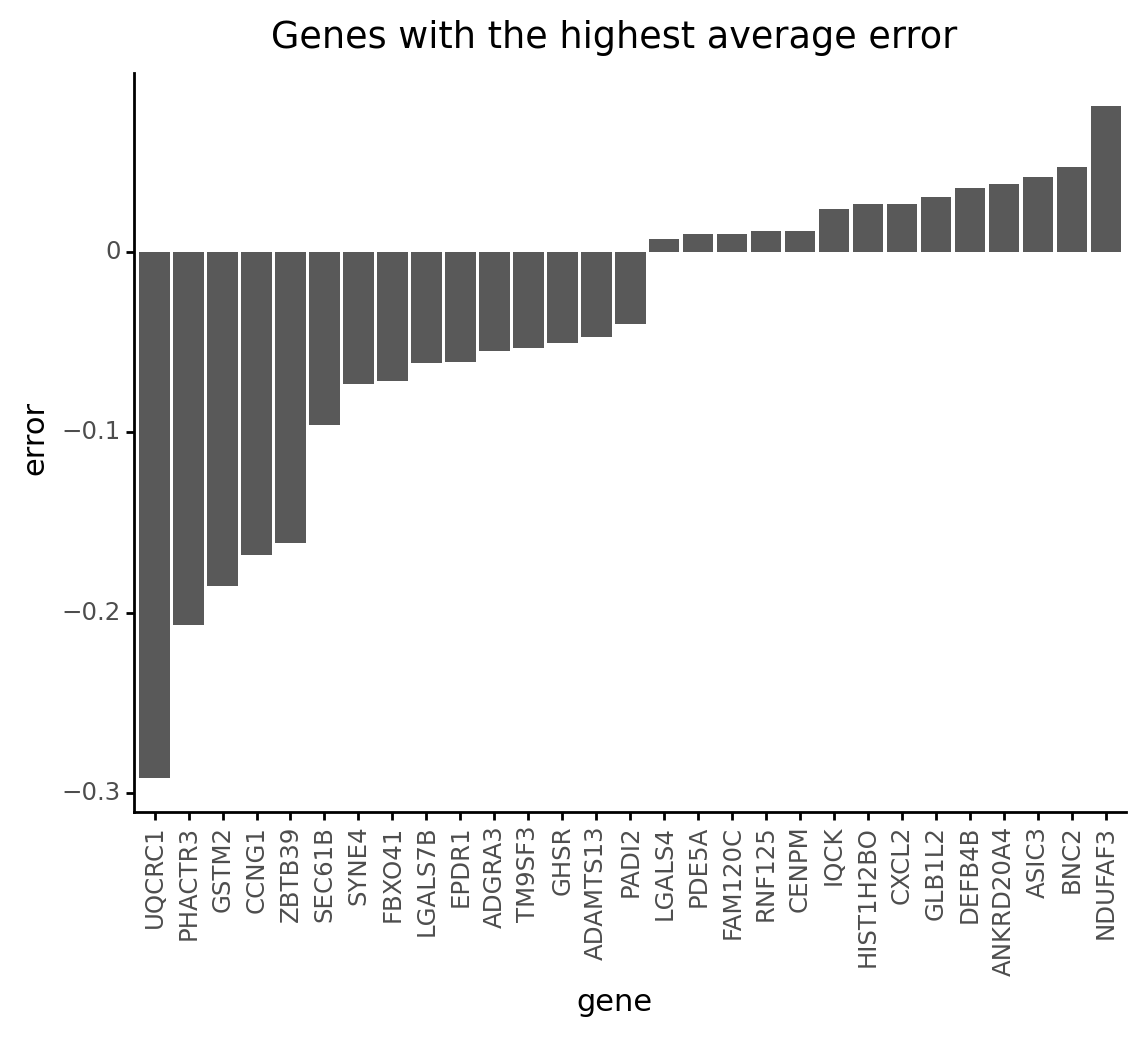

<ggplot: (2955128728941)>

In [26]:
gene_error = (
    pred_summary.groupby(["hugo_symbol"])["error"]
    .agg([np.mean, np.std])
    .reset_index(drop=False)
    .sort_values(["mean"])
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.astype(str),
            categories=d.hugo_symbol.astype(str),
            ordered=True,
        )
    )
)

n_genes = 15

(
    gg.ggplot(
        gene_error.iloc[list(range(n_genes)) + list(range(-n_genes, -1))],
        gg.aes(x="hugo_symbol", y="mean"),
    )
    + gg.geom_col()
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="gene", y="error", title="Genes with the highest average error")
)

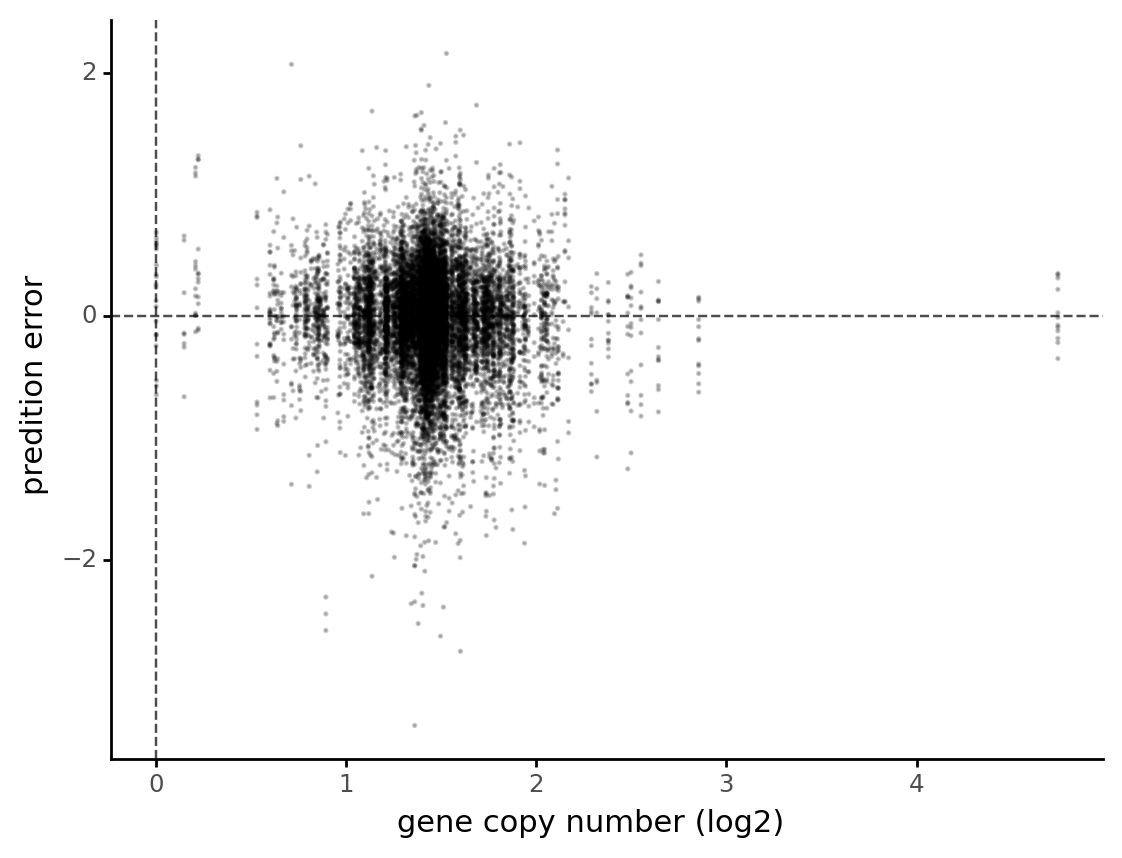

<ggplot: (2955507112183)>

In [27]:
(
    gg.ggplot(pred_summary, gg.aes(x="log2_cn", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="gene copy number (log2)", y="predition error")
)

---

In [28]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 15.78 minutes


In [29]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-05-26

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-72.o2.rc.hms.harvard.edu

Git branch: noncentered-reparam

matplotlib: 3.3.4
arviz     : 0.11.2
seaborn   : 0.11.1
pandas    : 1.2.3
pymc3     : 3.11.1
plotnine  : 0.7.1
numpy     : 1.20.1

